# Time-Killer Experiments

## Dependencies

In [1]:
#import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
%matplotlib inline

from math import sqrt
SPINE_COLOR = 'gray'

## Latex Style (Optional)

In [2]:

# Style parameters
pd.set_option('display.mpl_style', 'default') 
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 50)
pd.options.display.mpl_style = 'default'
new_style = {'grid': True}
mpl.rc('axes', **new_style)

# cool colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  

#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 10}

#mpl.rc('font', **font)

#Direct input 
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 10,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 
fig = plt.figure()

#You must select the correct size of the plot in advance
#fig.set_size_inches(3.54,3.54) 

def legendaryFormat(leg, resize=True):
    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('white')

    # Set the fontsize
    if(resize):
        for label in legend.get_texts():
            label.set_fontsize('large')
        for label in legend.get_lines():
            label.set_linewidth(2)  # the legend line width
        
        
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': ['\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 10,
              'text.fontsize': 9, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'font.family' : 'helvetica',
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    mpl.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax


In [3]:
%matplotlib inline

In [4]:
#run for latex-optimised generation
latexify()

/Users/carbone/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Data Preparation & Cleaning

In [11]:

class ExpLoader():
    
    @staticmethod
    def enrich(str, df):
        dirs = str.split('/');
        df['experiment'] = dirs[2];
        df['system'] = dirs[1];
        return df
    
    @staticmethod
    def loadDataFrame(rootDir = 'experiments'):
        dataDirs = filter(lambda y: [s for s in y[2] if ".csv" in s],([x for x in os.walk("experiments")]))
        DF = reduce(lambda r1,r2: pd.concat([r1,r2]), 
                map(lambda d: ExpLoader.enrich(d[0],  
                reduce(lambda f1,f2: pd.concat([f1,f2]),
                map(lambda x: pd.read_csv(d[0] +'/'+ x, delimiter=',', index_col=[1]),
                    filter(lambda y: ".csv" in y ,d[2])))), dataDirs))
        DF['local time'] = DF['local_End'] - DF['window_Start']
        DF['notif time'] = DF['window_End'] - DF['local_End']
        DF['full time'] = DF['window_End'] - DF['window_Start']
        DF['parallelism'] = DF.index
        DF['step'] = DF['step'] - 1
        return DF[(DF['step'] > 0) & (DF['step'] < 999999999)]
    
DF = ExpLoader.loadDataFrame()    
#compare dataset sizes
print 'Time-Killer: #loops:'+str(DF[(DF[DF.system.name] == 'watermarks')].size)
print 'Timely: #loops:'+str(DF[(DF[DF.system.name] == 'timely')].size)

#DF

Time-Killer: #loops:138880
Timely: #loops:139200


# Visualization

## Preperation

In [4]:
class Alg:
    pagerank = "pagerank"
    connectedComponents = "cc"

class ProgressType:
    decentralized = "watermarks"
    centralized = "timely"
    
class Aggregate:
    full = 'full time'
    notification = 'notif time'
    computation = 'local time'
    
def filterDF(dataframe, *extrafilters):
    newDF = dataframe;
    for extrafilter in extrafilters:
        newDF = extrafilter(newDF);
    return newDF
    
def filterDF2(dataframe, alg, prog, *extrafilters):
    return filterDF(dataframe[(dataframe[DF.experiment.name] == alg) & (dataframe[DF.system.name] == prog)], *extrafilters)

class Filters:
    @staticmethod
    def highCap(agg, val, incl=False):
        return (lambda dataframe: dataframe[(dataframe[agg] < val)]) if not incl else (lambda dataframe: dataframe[(dataframe[agg] <= val)])
    @staticmethod
    def lowCap(agg, val, incl=False):
        return (lambda dataframe: dataframe[(dataframe[agg] > val)]) if not incl else (lambda dataframe: dataframe[(dataframe[agg] >= val)]);
    @staticmethod
    def point(agg, val, ignore=False):
        return (lambda dataframe: dataframe[(dataframe[agg] != val)]) if ignore else (lambda dataframe: dataframe[(dataframe[agg] == val)]);

class ExpPlots:
    @staticmethod
    def box1(dataframe, col, grouped):
        return dataframe.boxplot(column=col, by=grouped, meanline=True, showmeans=True, showcaps=True, showbox=True, showfliers=True, return_type='axes')
    @staticmethod
    def box(dataframe, col, grouped, axis):
        dataframe.boxplot(column=col, by=grouped, meanline=True, showmeans=True, showcaps=True, showbox=True, showfliers=True, ax=axis)
    @staticmethod
    def boxPlots(dataframe1, dataframe2, col, grouped):
        ax = ExpPlots.box1(dataframe1, col, grouped)
        ExpPlots.box(dataframe2, col, grouped, ax)
    

## Exploration

### Pre-Compute

In [5]:
timelyCC = filterDF2(DF, Alg.connectedComponents, ProgressType.centralized, 
                        Filters.highCap(Aggregate.full, 15000),
                        Filters.highCap(Aggregate.notification, 8000), 
                        Filters.lowCap(DF.step.name, 1));
timelyPR = filterDF2(DF, Alg.pagerank, ProgressType.centralized, 
                        Filters.highCap(Aggregate.full, 15000), 
                        Filters.highCap(Aggregate.notification, 8000), 
                        Filters.lowCap(DF.step.name, 1));
timekillCC = filterDF2(DF, Alg.connectedComponents, ProgressType.decentralized, 
                        Filters.highCap(Aggregate.full, 15000), 
                        Filters.highCap(Aggregate.notification, 8000),  
                        Filters.lowCap(DF.step.name, 1));
timekillPR = filterDF2(DF, Alg.pagerank, ProgressType.decentralized, 
                        Filters.highCap(Aggregate.full, 15000), 
                        Filters.highCap(Aggregate.notification, 8000), 
                        Filters.lowCap(DF.step.name, 1));

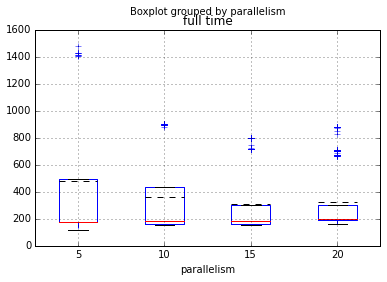

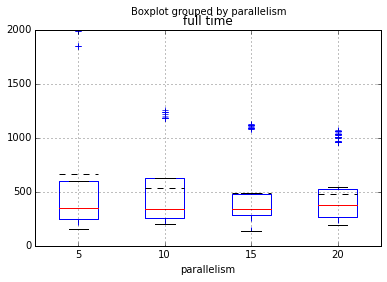

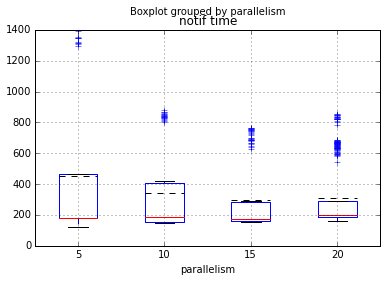

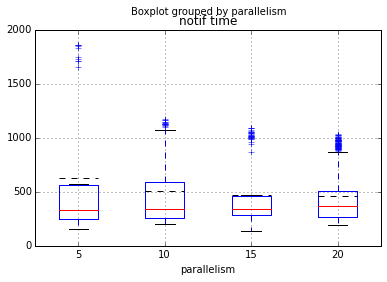

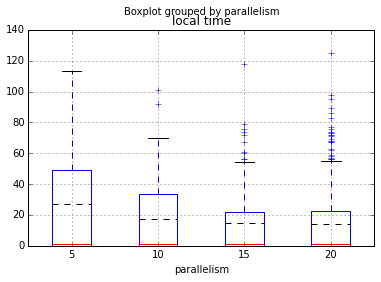

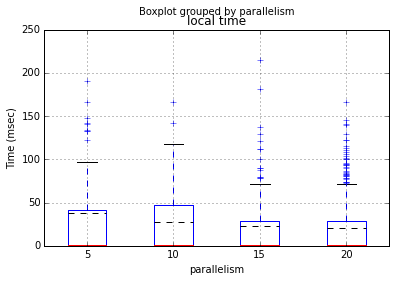

In [50]:
#numOfWindows==1, group by parallelism
myDF = filterDF(timekillCC, Filters.point(DF.num_Windows.name, 1))
myDF2 = filterDF(timelyCC, Filters.point(DF.num_Windows.name, 1))

ExpPlots.box1(myDF, Aggregate.full, DF.parallelism.name);
ExpPlots.box1(myDF2, Aggregate.full, DF.parallelism.name);
ExpPlots.box1(myDF, Aggregate.notification, DF.parallelism.name);
ExpPlots.box1(myDF2, Aggregate.notification, DF.parallelism.name);
ExpPlots.box1(myDF, Aggregate.computation, DF.parallelism.name);
ExpPlots.box1(myDF2, Aggregate.computation, DF.parallelism.name);
#plt.tight_layout()
plt.ylabel('Time (msec)')
#plt.savefig('expnotif2.pdf', bbox_inches='tight')


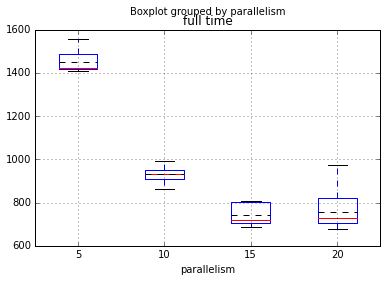

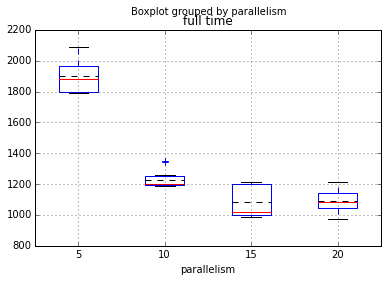

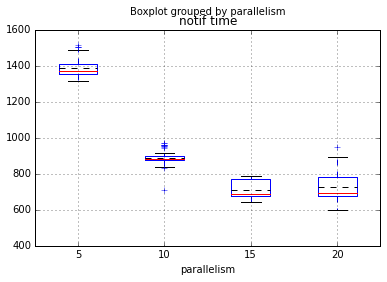

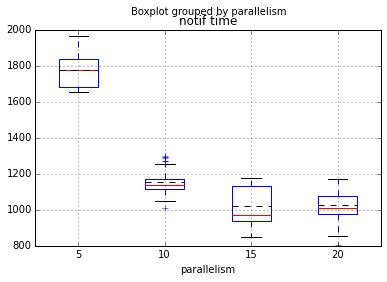

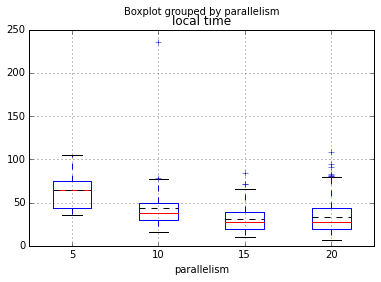

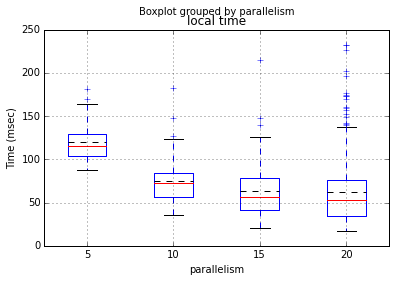

In [10]:
#numOfWindows==1, group by parallelism
myDF = filterDF(timekillPR, Filters.point(DF.num_Windows.name, 1))
myDF2 = filterDF(timelyPR, Filters.point(DF.num_Windows.name, 1))

ExpPlots.box1(myDF, Aggregate.full, DF.parallelism.name);
ExpPlots.box1(myDF2, Aggregate.full, DF.parallelism.name);
ExpPlots.box1(myDF, Aggregate.notification, DF.parallelism.name);
ExpPlots.box1(myDF2, Aggregate.notification, DF.parallelism.name);
ExpPlots.box1(myDF, Aggregate.computation, DF.parallelism.name);
ExpPlots.box1(myDF2, Aggregate.computation, DF.parallelism.name);
#plt.tight_layout()
plt.ylabel('Time (msec)')
#plt.savefig('expnotif2.pdf', bbox_inches='tight')


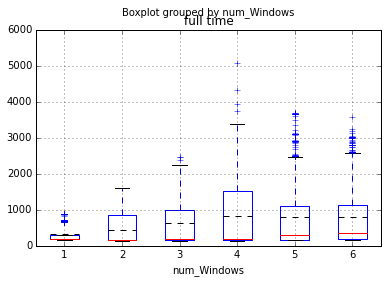

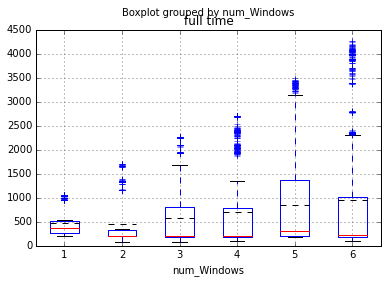

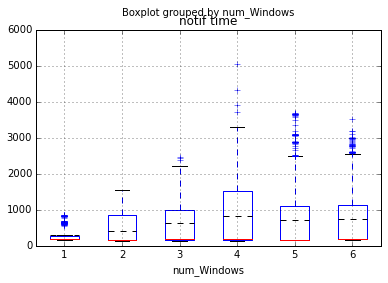

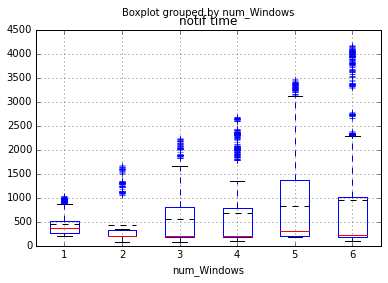

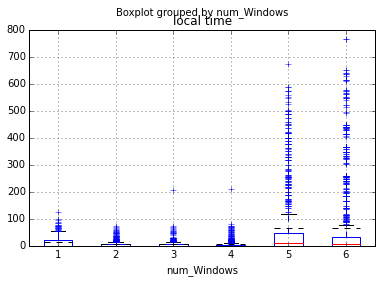

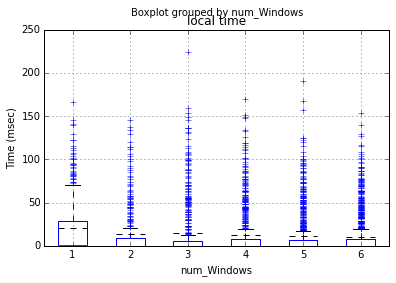

In [8]:
#parallelism==20, group by numWindows
myDF = filterDF(timekillCC, Filters.point(DF.parallelism.name, 20))
myDF2 = filterDF(timelyCC, Filters.point(DF.parallelism.name, 20))

ExpPlots.box1(myDF, Aggregate.full, DF.num_Windows.name);
ExpPlots.box1(myDF2, Aggregate.full, DF.num_Windows.name);
ExpPlots.box1(myDF, Aggregate.notification, DF.num_Windows.name);
ExpPlots.box1(myDF2, Aggregate.notification, DF.num_Windows.name);
ExpPlots.box1(myDF, Aggregate.computation, DF.num_Windows.name);
ExpPlots.box1(myDF2, Aggregate.computation, DF.num_Windows.name);
#plt.tight_layout()
plt.ylabel('Time (msec)')
#plt.savefig('expnotif2.pdf', bbox_inches='tight')


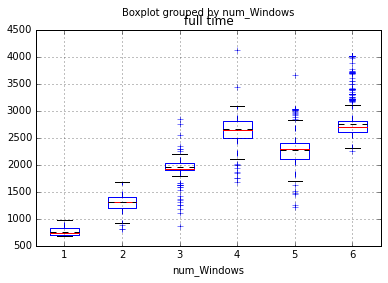

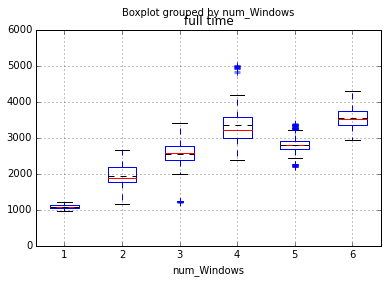

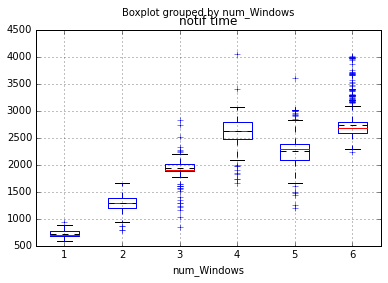

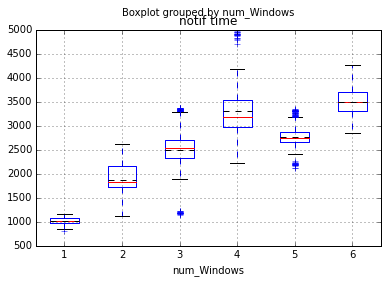

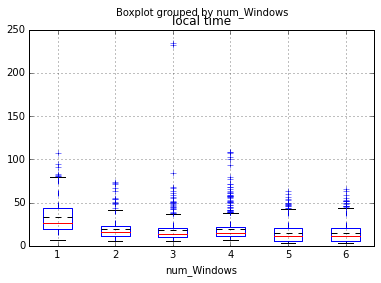

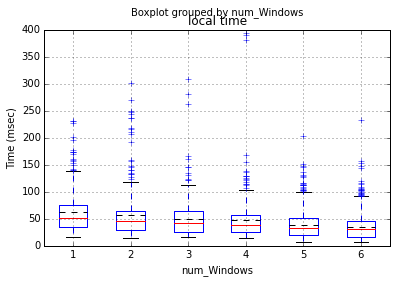

In [9]:
#parallelism==20, group by numWindows
myDF = filterDF(timekillPR, Filters.point(DF.parallelism.name, 20))
myDF2 = filterDF(timelyPR, Filters.point(DF.parallelism.name, 20))

ExpPlots.box1(myDF, Aggregate.full, DF.num_Windows.name);
ExpPlots.box1(myDF2, Aggregate.full, DF.num_Windows.name);
ExpPlots.box1(myDF, Aggregate.notification, DF.num_Windows.name);
ExpPlots.box1(myDF2, Aggregate.notification, DF.num_Windows.name);
ExpPlots.box1(myDF, Aggregate.computation, DF.num_Windows.name);
ExpPlots.box1(myDF2, Aggregate.computation, DF.num_Windows.name);
#plt.tight_layout()
plt.ylabel('Time (msec)')
#plt.savefig('expnotif2.pdf', bbox_inches='tight')


In [ ]:



ExpPlots.box1(timelyCC, Aggregate.notification, DF.parallelism.name);
axes = plt.gca()
#plt.tight_layout()
plt.ylabel('Time (msec)')
#plt.savefig('expnotif2.pdf', bbox_inches='tight')


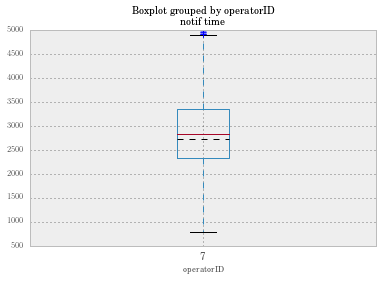

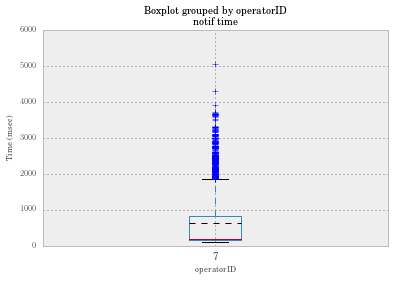

In [215]:
timelyCC = filterDF2(DF, Alg.pagerank, ProgressType.centralized, 
                        Filters.highCap(Aggregate.notification, 10000), 
                        Filters.lowCap(DF.step.name, 1),
                        Filters.highCap(Aggregate.full, 10000));

watermarksCC = filterDF2(DF, Alg.connectedComponents, ProgressType.decentralized, 
                        Filters.highCap(Aggregate.notification, 10000), 
                        Filters.lowCap(DF.step.name, 1),
                        Filters.highCap(Aggregate.full, 10000));

ExpPlots.box1(timelyCC, Aggregate.notification, DF.operatorID.name)
ExpPlots.box1(watermarksCC, Aggregate.notification, DF.operatorID.name)

#ExpPlots.boxPlots(timelyCC, watermarksCC, Aggregate.full, DF.operatorID)
#axes = plt.gca();
#plt.tight_layout()
plt.ylabel('Time (msec)')
#plt.savefig('expnotif2.pdf', bbox_inches='tight')


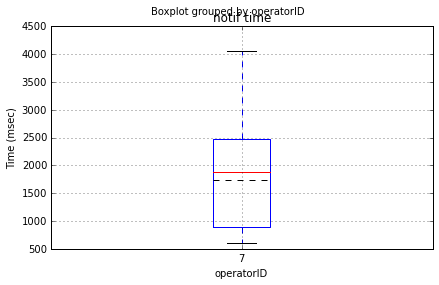

In [4]:
#timelyCC = DF[(DF['experiment'] == 'cc') & (DF['system'] == 'timely') & (DF['notif time'] < 5000)]    
watermarksCC = DF[(DF['experiment'] == 'pagerank') & (DF['system'] == 'watermarks')& (DF['full time'] < 5000) 
                  & (DF['step'] != 9223372036854775807)  & (DF['step'] > 1)] 

#watermarksCC = DF[ (DF['system'] == 'watermarks')& (DF['notif time'] < 2000)] 

#timelyCC.boxplot(column='notif time', by='ctxid', meanline=True, showmeans=True, showcaps=True, showbox=True, showfliers=True)

#watermarksCC.boxplot(column='notif time', by='ctxid', meanline=True, showmeans=True, showcaps=True, showbox=True, showfliers=True)

watermarksCC.boxplot(column='notif time', by='operatorID', meanline=True, showmeans=True, showcaps=True, showbox=True, showfliers=True)

#DFU = byWindow.unstack('ctxid');

#fig, axes = subplots('notif time');

#ax = DFU['notif time'].boxplot(subplots = True, meanline=True, showmeans=True, showcaps=True, showbox=True, showfliers=True)


axes = plt.gca()
#axes.set_ylim([0,90000])


plt.tight_layout()
plt.ylabel('Time (msec)')
plt.savefig('expnotif2.pdf', bbox_inches='tight')
